<a href="https://colab.research.google.com/github/jailan-mahmoud/Lesion-Segmentation/blob/main/Assignment_4_Lesion_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 4: Lesion Segmentation <br>
Done by:<br>
> Jailan Mahmoud - 5733 <br>
  Salma ElBanna - 5734


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue Feb  1 12:55:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install required librarires

In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 8.4 MB/s 
     |████████████████████████████████| 948 kB 64.0 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=13ec1e17e75a5e0bbc9cb48fd4da5971ba279c5cea75cf690dfefbd91f97bbcd
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


Imports

In [ ]:
# To mount Google Drive
from google.colab import drive

# OS
import os

# Other
import time
import glob
import numpy as np
from zipfile import ZipFile
import random

# Images
import cv2
from PIL import Image

# Plotting
import matplotlib.pyplot as plt

## Image Transforms
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

## PyTorch 
import torch
# 1. Datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
# 2. Model
from torchvision import models
from torch.nn import Sequential, ConvTranspose2d, Conv2d, MaxPool2d, Module, ModuleList, ReLU, Sequential, BatchNorm2d
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torchsummary import summary
# 3. Training Loop
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torchvision import transforms
from imutils import paths

# Progress Bar
from tqdm import tqdm

# EXTRA 
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.optim as optim
import torchvision

Mount Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Global Parameters

In [ ]:
# Device 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device in use = {DEVICE}')

# Number of Classes (= 1 for binary segmentation)
NUM_CLASSES = 1    # Background and Foreground -> Binary

# Image Input Size
IMAGE_HEIGHT = 300  # 767 originally
IMAGE_WIDTH= 400    # 1022 originally

Device in use = cuda


Seed everything

In [ ]:
SEED = 0
def seed_everything(seed):
  torch.cuda.seed_all()
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
seed_everything(SEED)

# 1. Unzip Dataset

In [ ]:
# Dataset Path
dataset_path = '/content/drive/MyDrive/ISIC-2017'

# Zip Files (Not used - can be used to make sure zip file exists)
train_zip = os.path.join(dataset_path, 'Train.zip')
val_zip = os.path.join(dataset_path, 'Validation.zip')
test_zip = os.path.join(dataset_path, 'Test.zip')

# Directory to unzip files in
train_dir = os.path.join(dataset_path, 'Train')
val_dir = os.path.join(dataset_path, 'Validation')
test_dir= os.path.join(dataset_path, 'Test')

In [ ]:
# Unzip Train.zip
if not os.path.exists(train_dir):
  if os.path.exists(train_zip): 
    with ZipFile(train_zip, 'r') as zipObj:
      zipObj.extractall(train_dir)
  else: print('Train.zip does not exist')
else: print('Train.zip has already been extracted.')

# Unzip Validation.zip
if not os.path.exists(val_dir):
  if os.path.exists(val_zip): 
    with ZipFile(test_zip, 'r') as zipObj:
      zipObj.extractall(test_dir)
  else: print('Validation.zip does not exist')
else: print('Validation.zip has already been extracted.')

# Unzip Test.zip
if not os.path.exists(test_dir):
  if os.path.exists(test_zip): 
    with ZipFile(test_zip, 'r') as zipObj:
      zipObj.extractall(test_dir)
  else: print('Test.zip does not exist')
else: print('Test.zip has already been extracted.')

Train.zip has already been extracted.
Validation.zip has already been extracted.
Test.zip has already been extracted.


# 2. Dataset

Dataset Class

In [ ]:
class ISIC_Dataset(Dataset):

  def __init__(self, directory, transform=None, small_sample=0):

    self.directory = directory
    self.transform = transform

    data_path = directory + '/Data/*.jpg'
    gt_path = directory + '/GroundTruth/*.png'

    self.Data_paths = sorted(glob.glob(data_path), key=lambda x: int(os.path.splitext(x)[0].split('_')[1]))
    self.GroundTruth_paths = sorted(glob.glob(gt_path), key=lambda x: int(os.path.splitext(x)[0].split('_')[1]))

    # If small sample of the dataset is required (for hypertuning) (small_sample should be input as an int)
    if small_sample:
      self.Data_paths = self.Data_paths[0:small_sample]
      self.GroundTruth_paths = self.GroundTruth_paths[0:small_sample]

  def __len__(self):  
    return len(self.Data_paths)

  def __getitem__(self, index):
    
    # read image and corresponding mask
    image = np.array(Image.open(self.Data_paths[index]).convert("RGB"))
    mask = np.array(Image.open(self.GroundTruth_paths[index]).convert("L"), dtype=np.float32) #read mask in grayscale mode

    # thresholding (convert the mask to 0, and 1 values before feeding it to the network)
    mask[mask < 128] = 0
    mask[mask >= 128] = 1
    
    # Transforms 
    if self.transform:
      transformed = self.transform(image=image, mask=mask)
      image = transformed["image"]
      mask = transformed["mask"]

    return [image, mask]

Visualize a sample

[INFO] Total Images in Train Set = 2000


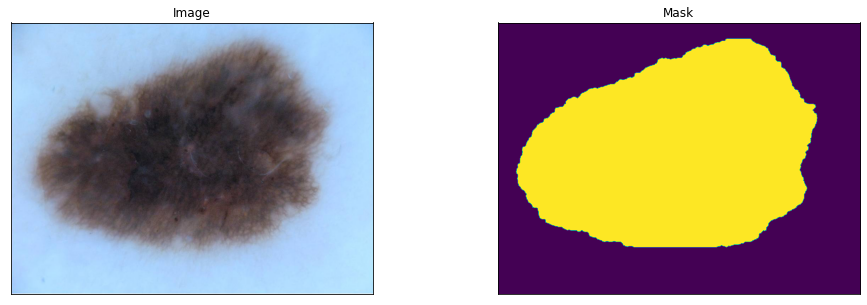

Image shape:  (767, 1022, 3)
Mask shape:  (767, 1022)
Image unique values:  [ 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show() 

# Test
dataset = ISIC_Dataset(directory = train_dir)
print(f'[INFO] Total Images in Train Set = {dataset.__len__()}')
img, mask = dataset.__getitem__(0)

visualize(
    Image = img,
    Mask = mask
)

print('Image shape: ',img.shape)
print('Mask shape: ',mask.shape)

print('Image unique values: ', np.unique(img))
print('Mask unique values: ', np.unique(mask))

# 3. Models

> ## 1. FCN

For deconvolution: [Link](https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/)

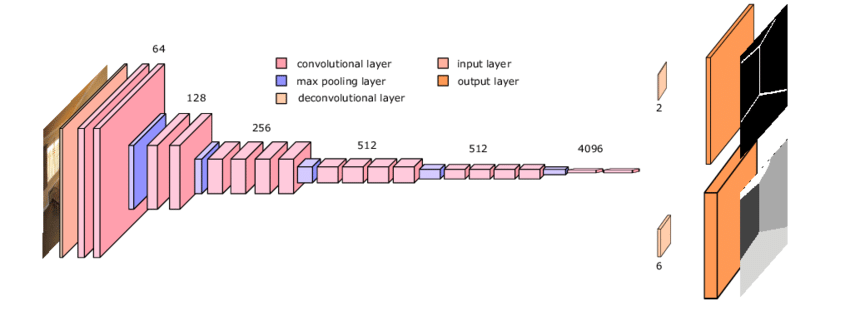

In [ ]:
class FCN_VGG16(Module):
  def __init__(self, num_classes=NUM_CLASSES, pretrained=False):
    super(FCN_VGG16, self).__init__()

    # VGG-16 Model
    vgg16 = models.vgg16(pretrained=pretrained)

		# Extract VGG-16 Feature Layers
    self.features = vgg16.features

		# Extract VGG-16 Average Pooling Layer
    # self.pooling = vgg16.avgpool            (-> Don't need it)

		# Extract the 3 fully-connected layers and replace them with 1*1 conv
    vgg16.classifier[0] = Conv2d(512, 4096, kernel_size=1, padding='same')
    vgg16.classifier[3] = Conv2d(4096, 4096, kernel_size=1, padding='same')
    vgg16.classifier[6] = Conv2d(4096, num_classes, kernel_size=1, padding='same')

    # 1*1 Convolution Layers
    self.conv_1_1 = vgg16.classifier

    # Deconvolution Layer
    self.upconv = ConvTranspose2d(num_classes, num_classes, kernel_size=48, stride=32) # upsampling by a factor of 32

  def forward(self, x):
		# It will take the input 'x' until it returns the feature vector called 'out'
    out = self.features(x)
    out = self.conv_1_1(out) 
    out = self.upconv(out)

    # reshape to input size 
    out = CenterCrop((IMAGE_HEIGHT,IMAGE_WIDTH))(out)

    return out 

In [ ]:
# Check Model
fcn = FCN_VGG16()
fcn.to(device=DEVICE)
summary(fcn, (3,IMAGE_HEIGHT,IMAGE_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 400]           1,792
              ReLU-2         [-1, 64, 300, 400]               0
            Conv2d-3         [-1, 64, 300, 400]          36,928
              ReLU-4         [-1, 64, 300, 400]               0
         MaxPool2d-5         [-1, 64, 150, 200]               0
            Conv2d-6        [-1, 128, 150, 200]          73,856
              ReLU-7        [-1, 128, 150, 200]               0
            Conv2d-8        [-1, 128, 150, 200]         147,584
              ReLU-9        [-1, 128, 150, 200]               0
        MaxPool2d-10         [-1, 128, 75, 100]               0
           Conv2d-11         [-1, 256, 75, 100]         295,168
             ReLU-12         [-1, 256, 75, 100]               0
           Conv2d-13         [-1, 256, 75, 100]         590,080
             ReLU-14         [-1, 256, 

> ## 2. UNet
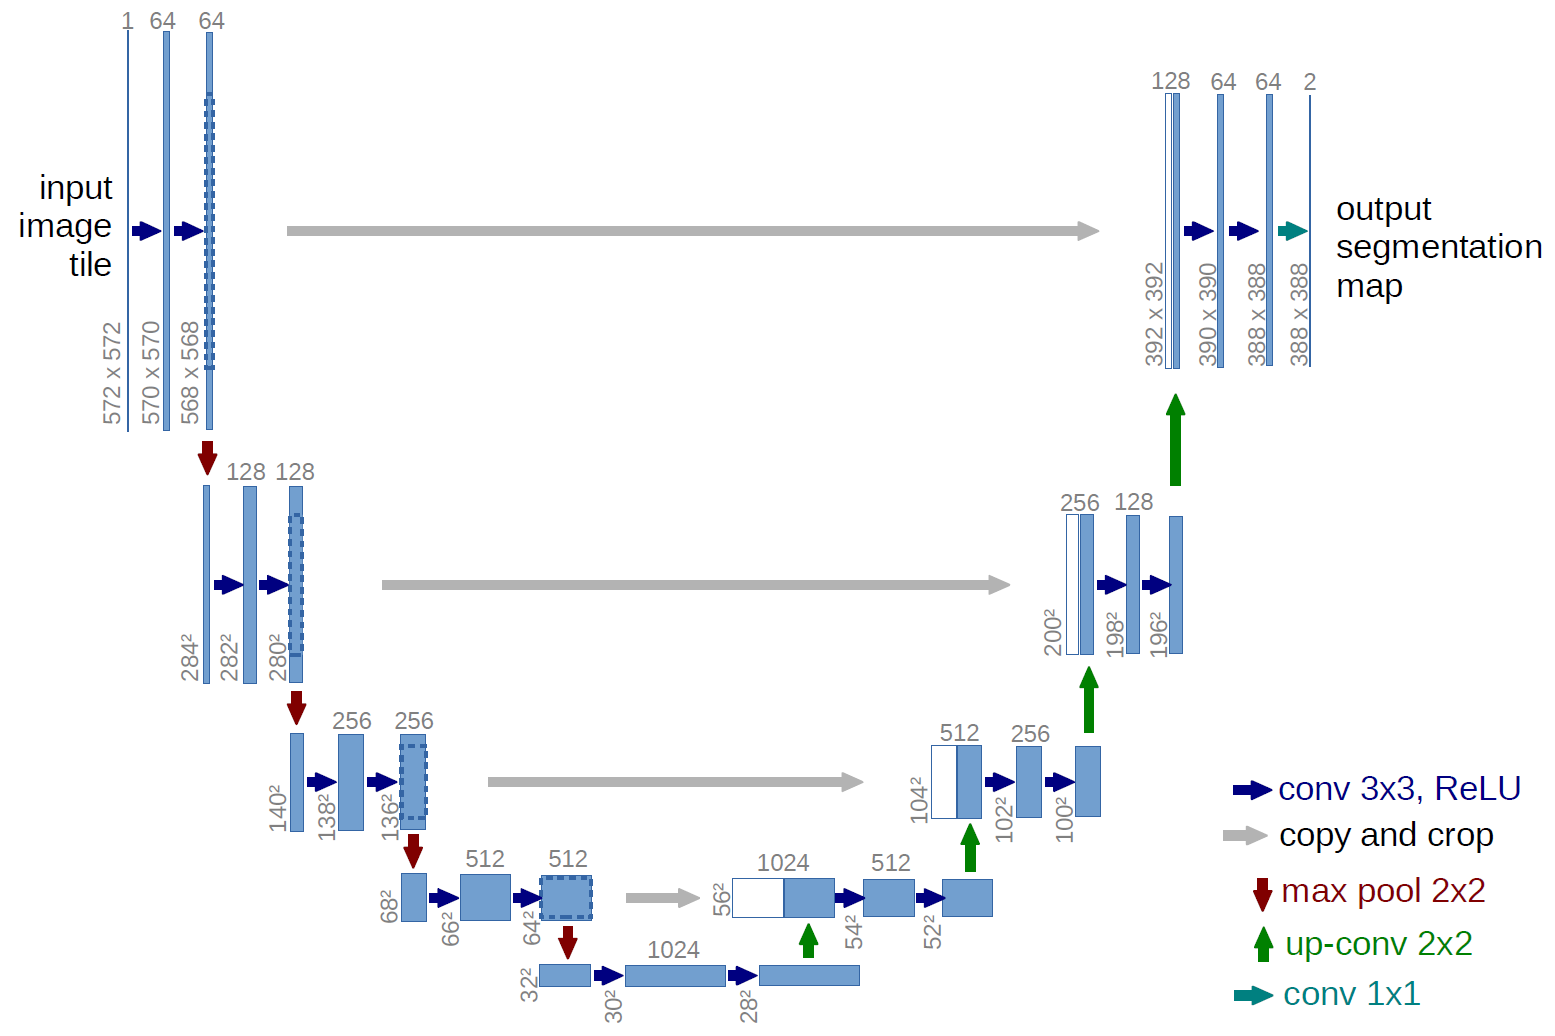

> ### 1. ORIGINAL

1. Block:

> Conv -> ReLU -> Conv -> ReLU

In [ ]:
'''
ORIGINAL
'''
class Block(Module):
  # store the convolution and RELU layers
	# inchannels: number of input channels (= filter depth), 
  # outChannels: number of output channels (= number of filters)
	def __init__(self, inChannels, outChannels):
		super(Block, self).__init__()
		self.block = Sequential(
				Conv2d(inChannels, outChannels, kernel_size=3, padding='same'), 	# padding: default -> valid (unpadded convolution)
				ReLU(inplace=True),
		 		Conv2d(outChannels, outChannels, kernel_size=3, padding='same'),
				ReLU(inplace=True)
		)
																														
  # apply CONV => RELU => CONV => RELU block to the inputs and return it
	def forward(self, x):
		return self.block(x)

2. Encoder

In [ ]:
class Encoder(Module):

	# store the encoder blocks and maxpooling layer
	def __init__(self, in_channels=3, num_feature_maps=[64,128,256,512]): 
		super(Encoder, self).__init__()
	
		# Create encoder blocks
		self.encBlocks = ModuleList()
		for feature in num_feature_maps:
			self.encBlocks.append(Block(in_channels, feature))
			in_channels = feature

		# Create MaxPool Layer	
		self.pool = MaxPool2d(kernel_size=2, stride=2)
	
		# Create bottleneck layer
		self.bottleneck = Block(num_feature_maps[-1], num_feature_maps[-1]*2)

	def forward(self, x):
   
		# initialize an empty list to store the intermediate outputs
		skip_connections = []

		# loop through the encoder blocks
		for block in self.encBlocks:
			x = block(x) 	            		# 1. pass the inputs through the current encoder block,
			skip_connections.append(x)    # 2. store the outputs
			x = self.pool(x)          		# 3. apply maxpooling on the output
		
		# pass through bottleneck
		skip_connections.append(self.bottleneck(x))

		# return final output of the encoder AND the list containing the intermediate outputs (reversed)
		return skip_connections

3. Decoder

In [ ]:
class Decoder(Module):
  
	# initialize the number of channels, upsampler blocks and decoder blocks
	def __init__(self, num_feature_maps=[64,128,256,512]):
		super(Decoder, self).__init__()
	
		# Up part of UNET
		self.upconvs = ModuleList()
		self.dec_blocks = ModuleList()
		for feature in reversed(num_feature_maps):
			# 1. Upsampling using upconvolution
			self.upconvs.append(
					ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
			)
	 		# 2. Double 3x3 CONV (each followed by a ReLU)
			self.dec_blocks.append(Block(feature*2, feature))
  
	def forward(self, x, encFeatures):
   
		# loop through the number of channels
		for i in range(len(self.upconvs)):
			
			x = self.upconvs[i](x)                        # 1. pass the inputs through the upsampler blocks
			encFeat = encFeatures[i] 
			
			if(x.shape!=encFeatures[i].shape):						# 2. crop the current features from the encoder blocks (if sizes don't match in case of unpadded convolutions)
				encFeat = self.crop(encFeatures[i], x)      
		 	
			x = torch.cat([encFeat, x], dim=1)            # 3. concatenate them with the current upsampled features
			x = self.dec_blocks[i](x)                     # 4. pass the concatenated output through the current decoder block
   
		# return the final decoder output
		return x

	def crop(self, encFeatures, x):
	
		(_, _, H, W) = x.shape                                 	# grab the dimensions of the inputs
		encFeatures = CenterCrop([H, W])(encFeatures)           # crop the encoder features to match the dimensions
	
  	# return the cropped features
		return encFeatures

4. UNet Model

In [ ]:
class UNet(Module):
  
  def __init__(self, in_channels=3, num_classes=1, 
               num_feature_maps=[64,128,256,512], 
               retainDim=True,outSize=(IMAGE_HEIGHT,IMAGE_WIDTH)):
    
    super(UNet, self).__init__()
  
		# 1. initialize the encoder and decoder
    self.encoder = Encoder(in_channels, num_feature_maps)
    self.decoder = Decoder(num_feature_maps)
  
		# 2. initialize the final 1*1 CONV and store the class variables
    self.conv_1_1 = Conv2d(num_feature_maps[0], num_classes,  kernel_size=1)
    self.retainDim = retainDim
    self.outSize = outSize    
    
  def forward(self, x):
		# 1. grab the features from the encoder
    encFeatures = self.encoder(x)
    encOutput = encFeatures[::-1][0]
    encFeatures = encFeatures[::-1][1:]
    
		# 2. pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
    decFeatures = self.decoder(encOutput,encFeatures)
  
		# 3. pass the decoder features through the regression head to
		# obtain the segmentation mask
    map = self.conv_1_1(decFeatures)    # Do we need a sigmoid function??
  
		# 4. check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them 
    # CHECK IF THERE'S ANOTHER WAY TO DO THIS (OR if we can use padded convolutions) 
    if self.retainDim:
        map = F.interpolate(map, self.outSize)   
   
		# return the segmentation map
    return map

In [ ]:
# Check Model
unet = UNet().to(DEVICE)
summary(unet, (3,IMAGE_HEIGHT,IMAGE_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 400]           1,792
              ReLU-2         [-1, 64, 300, 400]               0
            Conv2d-3         [-1, 64, 300, 400]          36,928
              ReLU-4         [-1, 64, 300, 400]               0
             Block-5         [-1, 64, 300, 400]               0
         MaxPool2d-6         [-1, 64, 150, 200]               0
            Conv2d-7        [-1, 128, 150, 200]          73,856
              ReLU-8        [-1, 128, 150, 200]               0
            Conv2d-9        [-1, 128, 150, 200]         147,584
             ReLU-10        [-1, 128, 150, 200]               0
            Block-11        [-1, 128, 150, 200]               0
        MaxPool2d-12         [-1, 128, 75, 100]               0
           Conv2d-13         [-1, 256, 75, 100]         295,168
             ReLU-14         [-1, 256, 

> ### 2. WITH BATCH NORMALIZATION

In [ ]:
'''
WITH BATCH NORMALIZATION
'''
class Block_BN(Module):
  # store the convolution and RELU layers
	# inchannels: number of input channels (= filter depth), 
  # outChannels: number of output channels (= number of filters)
	def __init__(self, inChannels, outChannels):
		super(Block_BN, self).__init__()
		self.block = Sequential(
				Conv2d(inChannels, outChannels, kernel_size=3, padding='same'), 	# padding: default -> valid (unpadded convolution)
				BatchNorm2d(outChannels),
				ReLU(inplace=True),
		 		Conv2d(outChannels, outChannels, kernel_size=3, padding='same'),
				BatchNorm2d(outChannels),
				ReLU(inplace=True),	
		)
																														
  # apply CONV => RELU => CONV => RELU block to the inputs and return it
	def forward(self, x):
		return self.block(x)

In [ ]:
class Encoder_BN(Module):

	# store the encoder blocks and maxpooling layer
	def __init__(self, in_channels=3, num_feature_maps=[64,128,256,512]): 
		super(Encoder_BN, self).__init__()
	
		# Create encoder blocks
		self.encBlocks = ModuleList()
		for feature in num_feature_maps:
			self.encBlocks.append(Block_BN(in_channels, feature))
			in_channels = feature

		# Create MaxPool Layer	
		self.pool = MaxPool2d(kernel_size=2, stride=2)
	
		# Create bottleneck layer
		self.bottleneck = Block_BN(num_feature_maps[-1], num_feature_maps[-1]*2)

	def forward(self, x):
   
		# initialize an empty list to store the intermediate outputs
		skip_connections = []

		# loop through the encoder blocks
		for block in self.encBlocks:
			x = block(x) 	            		# 1. pass the inputs through the current encoder block,
			skip_connections.append(x)    # 2. store the outputs
			x = self.pool(x)          		# 3. apply maxpooling on the output
		
		# pass through bottleneck
		skip_connections.append(self.bottleneck(x))

		# return final output of the encoder AND the list containing the intermediate outputs (reversed)
		return skip_connections

3. Decoder

In [ ]:
class Decoder_BN(Module):
  
	# initialize the number of channels, upsampler blocks and decoder blocks
	def __init__(self, num_feature_maps=[64,128,256,512]):
		super(Decoder_BN, self).__init__()
	
		# Up part of UNET
		self.upconvs = ModuleList()
		self.dec_blocks = ModuleList()
		for feature in reversed(num_feature_maps):
			# 1. Upsampling using upconvolution
			self.upconvs.append(
					ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
			)
	 		# 2. Double 3x3 CONV (each followed by a ReLU)
			self.dec_blocks.append(Block_BN(feature*2, feature))
  
	def forward(self, x, encFeatures):
   
		# loop through the number of channels
		for i in range(len(self.upconvs)):
			
			x = self.upconvs[i](x)                        # 1. pass the inputs through the upsampler blocks
			encFeat = encFeatures[i] 
			if(x.shape!=encFeatures[i].shape):						# 2. crop the current features from the encoder blocks (if sizes don't match in case of unpadded convolutions)
				encFeat = self.crop(encFeatures[i], x)       	
			x = torch.cat([encFeat, x], dim=1)            # 3. concatenate them with the current upsampled features
			x = self.dec_blocks[i](x)                     # 4. pass the concatenated output through the current decoder block
   
		# return the final decoder output
		return x

	def crop(self, encFeatures, x):
	
		(_, _, H, W) = x.shape                                 	# grab the dimensions of the inputs
		encFeatures = CenterCrop([H, W])(encFeatures)           # crop the encoder features to match the dimensions
	
  	# return the cropped features
		return encFeatures

4. UNet Model

In [ ]:
class UNet_BN(Module):
  
  def __init__(self, in_channels=3, num_classes=1, 
               num_feature_maps=[64,128,256,512], 
               retainDim=True,outSize=(IMAGE_HEIGHT,IMAGE_WIDTH)):
    
    super(UNet_BN, self).__init__()
  
		# 1. initialize the encoder and decoder
    self.encoder = Encoder_BN(in_channels, num_feature_maps)
    self.decoder = Decoder_BN(num_feature_maps)
  
		# 2. initialize the final 1*1 CONV and store the class variables
    self.conv_1_1 = Conv2d(num_feature_maps[0], num_classes,  kernel_size=1)
    self.retainDim = retainDim
    self.outSize = outSize    
    
  def forward(self, x):
		# 1. grab the features from the encoder
    encFeatures = self.encoder(x)
    encOutput = encFeatures[::-1][0]
    encFeatures = encFeatures[::-1][1:]
    
		# 2. pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
    decFeatures = self.decoder(encOutput,encFeatures)
  
		# 3. pass the decoder features through the regression head to
		# obtain the segmentation mask
    map = self.conv_1_1(decFeatures)    # Do we need a sigmoid function??
  
		# 4. check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them 
    # CHECK IF THERE'S ANOTHER WAY TO DO THIS (OR if we can use padded convolutions) 
    if self.retainDim:
        map = F.interpolate(map, self.outSize)   
   
		# return the segmentation map
    return map

In [ ]:
# Check Model
unet = UNet_BN().to(DEVICE)
summary(unet, (3,IMAGE_HEIGHT,IMAGE_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 400]           1,792
       BatchNorm2d-2         [-1, 64, 300, 400]             128
              ReLU-3         [-1, 64, 300, 400]               0
            Conv2d-4         [-1, 64, 300, 400]          36,928
       BatchNorm2d-5         [-1, 64, 300, 400]             128
              ReLU-6         [-1, 64, 300, 400]               0
          Block_BN-7         [-1, 64, 300, 400]               0
         MaxPool2d-8         [-1, 64, 150, 200]               0
            Conv2d-9        [-1, 128, 150, 200]          73,856
      BatchNorm2d-10        [-1, 128, 150, 200]             256
             ReLU-11        [-1, 128, 150, 200]               0
           Conv2d-12        [-1, 128, 150, 200]         147,584
      BatchNorm2d-13        [-1, 128, 150, 200]             256
             ReLU-14        [-1, 128, 1

# 4. Utility Functions

> ### Checkpoints 

In [ ]:
# 1. Save Checkpoint Function
def save_checkpoint(model, optimizer, scaler,
                    epoch, val_loss, val_IoU, 
                    history, checkpoint_path):

    # Create Checkpoint
    checkpoint = {
        'model_state': model.state_dict(),
        'optimizer_state' : optimizer.state_dict(),
        'scaler_state': scaler.state_dict(),
        'epoch': epoch,
        'val_loss': val_loss,
        'val_IoU': val_IoU,
        'history': history
        }

    # Save Checkpoint
    torch.save(checkpoint, checkpoint_path)

# 2. Load Checkpoint Function
def load_checkpoint(model, checkpoint_model_path):

    scaler = torch.cuda.amp.GradScaler()
    optimizer = optim.Adam(model.parameters())

    # Check if checkpoint file exists
    if os.path.isfile(checkpoint_model_path):
        checkpoint = torch.load(checkpoint_model_path)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        scaler.load_state_dict(checkpoint['scaler_state'])

        states = {}
        for item in checkpoint.keys():
            if item not in ['model_state', 'optimizer_state', 'scaler_state']:
                states[item] = checkpoint[item]
          
        model = model.to(DEVICE)

        print("=> loaded checkpoint '{}'".format(checkpoint_model_path))

    else: 
        print("=> no checkpoint found at '{}'".format(checkpoint_model_path))
        return

    return model, optimizer, scaler, states

> ### Saving Predictions

In [ ]:
def save_predictions_as_imgs(loader, model, folder):

    # Create Folder (if it doesn't exist)
    if not os.path.exists(folder):
      os.mkdir(folder)

    model.eval()
    
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=DEVICE)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float() # if pred>0.5 -> 1 else 0

        torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")    # Predicted Mask
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/gt_{idx}.png") # True Mask

    model.train()

> ### IoU 

In [ ]:
# 1. IoU Metric Function
def get_IoU_score(prediction, target, threshold=0.5,smooth=0.0, eps=1e-7):
  assert prediction.size() == target.size()
  
  # 1. Thresholding (In place operation)
  preds = prediction.clone() # needed for thresholding
  condition = preds >= threshold
  preds[condition] = 1
  preds[~condition] = 0

  # 2. Calculate Intersection and Union
  intersection = torch.sum(preds * target)
  cardinality = torch.sum(preds + target)
  union = cardinality - intersection

  # 3. Finally, calculate IoU score
  iou_score = (intersection + smooth) / (union + smooth).clamp_min(eps)

  return iou_score

# 2. IoU Loss 
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    '''
    calculates IoU score (on probabilities)
    '''
    def forward(self, prediction, targets, smooth=0, eps=1e-7): 
        assert prediction.size() == targets.size()

        # 1. Thresholding (In place operation)
        # preds = prediction.clone() # needed for thresholding
        # condition = preds >= threshold
        # preds[condition] = 1
        # preds[~condition] = 0

        # 2. Calculate Intersection and Union
        intersection = torch.sum(prediction * targets)
        cardinality = torch.sum(prediction + targets)
        union = cardinality - intersection

        # 3. Finally, calculate IoU score
        iou_score = (intersection + smooth) / (union + smooth).clamp_min(eps)
                
        return 1.0 - iou_score

# 6. Train, Validation and Test Functions

> ### Train Loop

In [ ]:
def train_loop(train_loader,model, optimizer, lossFunc, scaler, epoch, epochs):

  model.train()

  totalTrainIoU = 0
  totalTrainLoss = 0
  totalPixelAccuracy = 0
  trainSteps = len(train_loader)

  loop = tqdm(enumerate(train_loader), total=len(train_loader))
  loop.set_description(f"EPOCH: {epoch}/{epochs} - Training") 
  
  for batch_idx, (img_batch,mask_batch) in loop: 
    # send the input to the device
    (img_batch, mask_batch) = (img_batch.to(DEVICE), mask_batch.float().unsqueeze(1).to(DEVICE))

    # Forward Pass
    with torch.cuda.amp.autocast():
      pred = torch.sigmoid(model(img_batch))
      loss = lossFunc(pred, mask_batch)
      IoU_score = get_IoU_score(pred, mask_batch) 
    
    # Backward Pass
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update progress bar 
    loop.set_postfix(IoU_score=IoU_score.item(), loss=1-IoU_score.item())

    # total loss and total IoU
    totalTrainLoss += 1-IoU_score
    totalTrainIoU += IoU_score
  
  # 1. Calculate avg IoU for CURRENT EPOCH
  avgTrainIoU = totalTrainIoU / trainSteps

  # 2. Calculate avg LOSS for CURRENT EPOCH
  avgTrainLoss = totalTrainLoss / trainSteps

  return model, optimizer, scaler, avgTrainLoss, avgTrainIoU

> ### Validation Loop

In [ ]:
def validation_loop(model,val_loader, lossFunc):

  model.eval()
  
  totalValIoU = 0
  totalValLoss = 0
  ValSteps = len(val_loader)

  loop = tqdm(enumerate(val_loader),total=len(val_loader))                  # Create validation loop
  loop.set_description(f"             - Validation")                        # Set description of validation loop

  # switch off autograd
  with torch.no_grad():
    for batch_idx, (img_batch, mask_batch) in loop:        
      # send the input to the device
      (img_batch, mask_batch) = (img_batch.to(DEVICE), mask_batch.float().unsqueeze(1).to(DEVICE))

      # make the predictions and calculate the validation loss
      pred = torch.sigmoid(model(img_batch))
      loss = lossFunc(pred, mask_batch)
      # IoU_score = 1 - loss
      IoU_score = get_IoU_score(pred, mask_batch) # leave it or change it?
      totalValLoss += 1 - IoU_score
      totalValIoU += IoU_score

      # update progress bar
      loop.set_postfix(IoU_score=IoU_score.item(), loss=1-IoU_score.item())
  
  # 1. Calculate avg validation IoU for CURRENT EPOCH
  avgValIoU = totalValIoU / ValSteps

  # 2. Calculate avg validation LOSS for CURRENT EPOCH
  avgValLoss = totalValLoss / ValSteps

  model.train()

  return avgValLoss, avgValIoU

> ### Train Function

In [ ]:
def train(model, epochs, train_loader, val_loader, 
          best_model_path, checkpoint_model_path, predictions_path,
          load_from_checkpoint=None, initial_lr=0.001):
  
  # Define first and last epochs
  first_epoch = 1
  last_epoch = epochs

  # Initialize a dictionary to store training history
  History = {"train_IoU": [], "val_IoU": [], "train_loss": [], "val_loss": []}

  # Best Loss (validation loss)
  best_loss = np.inf
  best_epoch = 1
  best_iou = 0

  # Create loss function, optimzer and scaler
  loss_fn = IoULoss()
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
  scaler = torch.cuda.amp.GradScaler()

  # Create a learning rate scheduler
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, min_lr=0.0000001)

  # Load Checkpoint
  if load_from_checkpoint:
      model, optimizer, scaler, states = load_checkpoint(model, best_model_path)
      best_epoch = states['epoch']
      best_iou = states['val_IoU']
      best_loss = states['val_loss']

      if load_from_checkpoint != 'best':
        model, optimizer, scaler, states = load_checkpoint(model, checkpoint_model_path)
      
      History = states['history']
      first_epoch = states['epoch'] + 1
  
      print('Model has been trained for {} epochs with best_IoU = {:.4f} and best_loss = {:.4f} at epoch {}\n'.format(
              states['epoch'], best_iou, best_loss, best_epoch))
    
  # Train
  for epoch in range(first_epoch, last_epoch+1):

    # 1. Train Loop
    model, optimizer, scaler, avgTrainLoss, avgTrainIoU = train_loop(train_loader, model, optimizer,
                                                                     loss_fn, scaler, epoch, epochs)

    # 2. Validation Loop
    avgValLoss, avgValIoU = validation_loop(model,val_loader, loss_fn)

    print(f'Avg Train Loss = {avgTrainLoss}, Avg Train IoU = {avgTrainIoU}, Avg Val Loss = {avgValLoss}, Avg Val IoU = {avgValIoU}  ')

    # 3. Update our training history
    History["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    History["val_loss"].append(avgValLoss.cpu().detach().numpy())
    History["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
    History["val_IoU"].append(avgValIoU.cpu().detach().numpy())

    # 4. Save Best Model
    if(avgValLoss < best_loss):
      save_checkpoint(model, optimizer, scaler, 
                      epoch, avgValLoss, avgValIoU, 
                      History, best_model_path)
      # update the best parameters
      best_loss = avgValLoss
      best_epoch = epoch
      best_iou = avgValIoU

      # Save predictions
      save_predictions_as_imgs(val_loader, model, predictions_path) 

      print("=> saved best model") 
    print()

    # 5. Save Current Model (after current epoch)
    save_checkpoint(model, optimizer, scaler, 
                    epoch, avgValLoss, avgValIoU,
                    History, checkpoint_model_path)
    
    # Learning Rate Scheduler
    scheduler.step(avgValLoss)
  
  print(f"Best val_loss = {best_loss} , Best val_score = {best_iou} at Epoch {best_epoch}.")

  # Return Model and History
  return model, History

> ### Test Function

In [ ]:
def test(model,test_loader, predictions_path):

  # initialize loss function and optimizer
  lossFunc = IoULoss() # Jaccard Loss

  # number of batches for test set 
  TestSteps = len(test_loader) 

  # loss and IoU
  totalTestLoss = 0
  totalTestIoU = 0

  loop = tqdm(enumerate(test_loader),total=len(test_loader))                  # Create validation loop
  loop.set_description(f"Testing: ")                                          # Set description of validation loop

  # switch off autograd
  with torch.no_grad():
    # set the model in evaluation mode
    model.eval()
    for batch_idx, (img_batch,mask_batch) in loop:
      # send the input to the device
      (img_batch, mask_batch) = (img_batch.to(DEVICE), mask_batch.float().unsqueeze(1).to(DEVICE))

      # make the predictions and calculate the validation loss
      pred = torch.sigmoid(model(img_batch))
      loss = lossFunc(pred, mask_batch)
      # IoU_score = 1 - loss
      IoU_score = get_IoU_score(pred, mask_batch) # leave it or change it?
      totalTestLoss += loss
      totalTestIoU += IoU_score

      # update progress bar
      loop.set_postfix(IoU_score=IoU_score.item(), loss=loss.item())
  
  # 1. Calculate avg validation IoU for CURRENT EPOCH
  avgTestIoU = totalTestIoU / TestSteps

  # 2. Calculate avg validation LOSS for CURRENT EPOCH
  avgTestLoss = totalTestLoss / TestSteps

  print(f'\nAvg Test Loss = {avgTestLoss}, Avg Test IoU = {avgTestIoU}')

  # Save predictions
  save_predictions_as_imgs(test_loader, model, predictions_path) 

  return avgTestLoss, avgTestIoU

# 7. Training

In [ ]:
# To clear GPU memory without restarting runtime (NOT WORKING)
torch.cuda.empty_cache()
!nvidia-smi

Tue Feb  1 12:56:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   1347MiB / 16280MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

> ### 1. Hyperparameters and Directories

In [ ]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
NUM_EPOCHS = 50
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False

# Dataset Path
dataset_path = '/content/drive/MyDrive/ISIC-2017'

# Directories
TRAIN_IMG_DIR = os.path.join(dataset_path, 'Train')
VAL_IMG_DIR = os.path.join(dataset_path, 'Validation')
TEST_IMG_DIR = os.path.join(dataset_path, 'Test')

In [ ]:
# Create models/checkpoints directory
models_path = os.path.join(dataset_path, "Models")
if not os.path.exists(models_path):
  os.mkdir(models_path)

# Predictions path
predictions_path = os.path.join(dataset_path, "Predictions")

# UNet Path
unet_predictions_path = os.path.join(predictions_path, "UNet")
unet_val_predictions_path = os.path.join(unet_predictions_path, "Validation") # will conatin several folders for each lr
unet_test_predictions_path = os.path.join(unet_predictions_path, "Test")

# FCN Path
fcn_predictions_path = os.path.join(predictions_path, "FCN")
fcn_val_predictions_path = os.path.join(fcn_predictions_path, "Validation") # will conatin several folders for each lr
fcn_test_predictions_path = os.path.join(fcn_predictions_path, "Test")

## Create Directories if they don't already exist
if not os.path.exists(predictions_path):
  os.mkdir(predictions_path)
# UNet
if not os.path.exists(unet_predictions_path):
  os.mkdir(unet_predictions_path)
if not os.path.exists(unet_val_predictions_path):
  os.mkdir(unet_val_predictions_path)
if not os.path.exists(unet_test_predictions_path):
  os.mkdir(unet_test_predictions_path)
# FCN
if not os.path.exists(fcn_predictions_path):
  os.mkdir(fcn_predictions_path)
if not os.path.exists(fcn_val_predictions_path):
  os.mkdir(fcn_val_predictions_path)
if not os.path.exists(fcn_test_predictions_path):
  os.mkdir(fcn_test_predictions_path)

> ### 2. Transforms and Dataloaders

In [ ]:
## 1. Transforms
# Train Transforms (with data augmentation)
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

# Validation Transform (NO data augmentation)
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)


### SMALL DATASETS FOR FINETUNING
## 2. Datasets
small_train_dataset = ISIC_Dataset(directory = train_dir, transform = train_transform, small_sample=500)
small_val_dataset = ISIC_Dataset(directory = val_dir, transform = val_transform, small_sample=50)

print("For finetuning:")
print(f"[INFO] found {len(small_train_dataset)} examples in the small training set ...")
print(f"[INFO] found {len(small_val_dataset)} examples in the small validation set ...")

## 3. Dataloaders
# Train Dataloader
small_train_loader = DataLoader(
    small_train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

# Validation Dataloader
small_val_loader = DataLoader(
    small_val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)
#################################################### 

### ENTIRE DATASET FOR TRAINING
## 2. Datasets 
train_dataset = ISIC_Dataset(directory = train_dir, transform = train_transform)
val_dataset = ISIC_Dataset(directory = val_dir, transform = val_transform)

print("\nFor training:")
print(f"[INFO] found {len(train_dataset)} examples in the training set...")
print(f"[INFO] found {len(val_dataset)} examples in the validation set...")

## 3. Dataloaders
# Train Dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

# Validation Dataloader
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

For finetuning:
[INFO] found 400 examples in the small training set ...
[INFO] found 50 examples in the small validation set ...

For training:
[INFO] found 2000 examples in the training set...
[INFO] found 150 examples in the validation set...


> ## 3. UNet Training <br>

>> ### Fine-tuning

1. lr = 0.01

In [ ]:
# Model Paths
best_model_path = os.path.join(models_path, "finetuning_0.01_best_unet.pth")
checkpoint_model_path = os.path.join(models_path, "finetuning_0.01_checkpoint_unet.pth")

# Predictions Path
predictions_path = os.path.join(unet_val_predictions_path, "Finetuning")

# Choose learning rate
initial_lr = 0.01

# Create model
model = UNet().to(DEVICE)

# Train model
model, History = train(model, 5, train_loader, val_loader, 
          best_model_path, checkpoint_model_path, predictions_path,
          load_from_checkpoint=None,
          initial_lr=initial_lr)

             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.30s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8061298727989197, Avg Train IoU = 0.19387021660804749, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.40s/it, IoU_score=0.62, loss=0.38]


Avg Train Loss = 0.8013203144073486, Avg Train IoU = 0.19867976009845734, Avg Val Loss = 0.7393876910209656, Avg Val IoU = 0.2606123387813568  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.40s/it, IoU_score=0.49, loss=0.51]


Avg Train Loss = 0.5947384834289551, Avg Train IoU = 0.40526139736175537, Avg Val Loss = 0.6878942847251892, Avg Val IoU = 0.3121057450771332  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.34s/it, IoU_score=0.599, loss=0.401]


Avg Train Loss = 0.5556933283805847, Avg Train IoU = 0.4443069100379944, Avg Val Loss = 0.6297634243965149, Avg Val IoU = 0.3702365756034851  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.35s/it, IoU_score=0.606, loss=0.394]


Avg Train Loss = 0.5508081316947937, Avg Train IoU = 0.44919198751449585, Avg Val Loss = 0.6338517665863037, Avg Val IoU = 0.3661482334136963  

Best val_loss = 0.6297634243965149 , Best val_score = 0.3702365756034851 at Epoch 4.


2. lr = 0.001

In [ ]:
# Model Paths
best_model_path = os.path.join(models_path, "finetuning_0.001_best_unet.pth")
checkpoint_model_path = os.path.join(models_path, "finetuning_0.001_checkpoint_unet.pth")

# Predictions Path
predictions_path = os.path.join(unet_val_predictions_path, "Finetuning")

# Choose learning rate
initial_lr = 0.001

# Create model
model = UNet().to(DEVICE)

# Train model
model, History = train(model, 5, train_loader, val_loader, 
          best_model_path, checkpoint_model_path, predictions_path,
          load_from_checkpoint=None,
          initial_lr=initial_lr)

             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.41s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8061298727989197, Avg Train IoU = 0.19387021660804749, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.43s/it, IoU_score=0.62, loss=0.38]


Avg Train Loss = 0.8013201951980591, Avg Train IoU = 0.1986798793077469, Avg Val Loss = 0.7393892407417297, Avg Val IoU = 0.2606107294559479  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.51s/it, IoU_score=0.49, loss=0.51]


Avg Train Loss = 0.5947363376617432, Avg Train IoU = 0.4052635431289673, Avg Val Loss = 0.687874972820282, Avg Val IoU = 0.3121251165866852  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.43s/it, IoU_score=0.599, loss=0.401]


Avg Train Loss = 0.5556926131248474, Avg Train IoU = 0.4443073272705078, Avg Val Loss = 0.6297556161880493, Avg Val IoU = 0.37024441361427307  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.37s/it, IoU_score=0.606, loss=0.394]


Avg Train Loss = 0.5508068799972534, Avg Train IoU = 0.44919320940971375, Avg Val Loss = 0.6338520050048828, Avg Val IoU = 0.3661479949951172  

Best val_loss = 0.6297556161880493 , Best val_score = 0.37024441361427307 at Epoch 4.


3. lr = 0.0001

In [ ]:
# Model Paths
best_model_path = os.path.join(models_path, "finetuning_0.0001_best_unet.pth")
checkpoint_model_path = os.path.join(models_path, "finetuning_0.0001_checkpoint_unet.pth")

# Predictions Path
predictions_path = os.path.join(unet_val_predictions_path, "Finetuning")

# Choose learning rate
initial_lr = 0.0001

# Create model
model = UNet().to(DEVICE)

# Train model
model, History = train(model, 5, train_loader, val_loader, 
          best_model_path, checkpoint_model_path, predictions_path,
          load_from_checkpoint=None,
          initial_lr=initial_lr)

             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.46s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8061298727989197, Avg Train IoU = 0.19387021660804749, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.40s/it, IoU_score=0.62, loss=0.38]


Avg Train Loss = 0.8013204336166382, Avg Train IoU = 0.1986796259880066, Avg Val Loss = 0.7393919825553894, Avg Val IoU = 0.260608047246933  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.41s/it, IoU_score=0.49, loss=0.51]


Avg Train Loss = 0.5947355628013611, Avg Train IoU = 0.40526437759399414, Avg Val Loss = 0.6878619194030762, Avg Val IoU = 0.31213805079460144  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.35s/it, IoU_score=0.599, loss=0.401]


Avg Train Loss = 0.5556918978691101, Avg Train IoU = 0.4443081319332123, Avg Val Loss = 0.6297618746757507, Avg Val IoU = 0.37023812532424927  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.23s/it, IoU_score=0.606, loss=0.394]


Avg Train Loss = 0.5508098602294922, Avg Train IoU = 0.44919025897979736, Avg Val Loss = 0.633851945400238, Avg Val IoU = 0.36614805459976196  

Best val_loss = 0.6297618746757507 , Best val_score = 0.37023812532424927 at Epoch 4.


>> ### Train Original UNet Model
*   Learning rate = 1e-4 (0.0001)
*   Batch size = 32

In [ ]:
# Model Paths
best_model_path = os.path.join(models_path, "trial_best_unet.pth")
checkpoint_model_path = os.path.join(models_path, "trial_checkpoint_unet.pth")

# Predictions Path
predictions_path = os.path.join(unet_val_predictions_path, "Trial")

# Choose learning rate
initial_lr = 1e-4

# Create model
model = UNet().to(DEVICE)

# Train model
model, History = train(model, 65, train_loader, val_loader, 
          best_model_path, checkpoint_model_path, predictions_path,
          load_from_checkpoint='last',
          initial_lr=initial_lr)

=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/trial_best_unet.pth'
=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/trial_checkpoint_unet.pth'
Model has been trained for 60 epochs with best_IoU = 0.6536 and best_loss = 0.3464 at epoch 49



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.25s/it, IoU_score=0.718, loss=0.282]


Avg Train Loss = 0.17616161704063416, Avg Train IoU = 0.8238597512245178, Avg Val Loss = 0.38068294525146484, Avg Val IoU = 0.6194210648536682  



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.42s/it, IoU_score=0.724, loss=0.276]


Avg Train Loss = 0.17953304946422577, Avg Train IoU = 0.8204900026321411, Avg Val Loss = 0.3578244149684906, Avg Val IoU = 0.6422598958015442  



             - Validation: 100%|██████████| 5/5 [00:38<00:00,  7.65s/it, IoU_score=0.742, loss=0.258]


Avg Train Loss = 0.17197977006435394, Avg Train IoU = 0.8280478119850159, Avg Val Loss = 0.3730471730232239, Avg Val IoU = 0.6270713806152344  



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.47s/it, IoU_score=0.729, loss=0.271]


Avg Train Loss = 0.1755969524383545, Avg Train IoU = 0.8244290351867676, Avg Val Loss = 0.3523923456668854, Avg Val IoU = 0.6476661562919617  



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.41s/it, IoU_score=0.736, loss=0.264]


Avg Train Loss = 0.16696538031101227, Avg Train IoU = 0.8330705165863037, Avg Val Loss = 0.3583098351955414, Avg Val IoU = 0.6417323350906372  

Best val_loss = 0.34644338488578796 , Best val_score = 0.6535566449165344 at Epoch 49.


=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/trial_checkpoint_unet.pth'


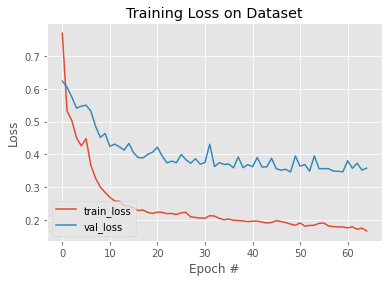

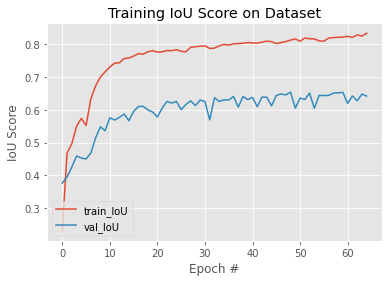

In [ ]:
# Best Model Path
model_path = os.path.join(models_path, "trial_checkpoint_unet.pth")

# Load Model
model = UNet().to(DEVICE)
model, optimizer, scaler, states = load_checkpoint(model, model_path)
History = states['history']

# 1. plot the loss curve
plt.style.use("ggplot")
plt.figure()
plt.plot(History["train_loss"], label="train_loss")
plt.plot(History["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
x = plt.show()

# Save the loss curve figure
# plt.savefig()

# 2. plot the IoU score curve
plt.style.use("ggplot")
plt.figure()
plt.plot(History["train_IoU"], label="train_IoU")
plt.plot(History["val_IoU"], label="val_IoU")
plt.title("Training IoU Score on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("IoU Score")
plt.legend(loc="lower left")
x = plt.show()

# Save the loss curve figure
# plt.savefig()

In [ ]:
# Train Loss and train accuracy at best epoch
print(History["train_loss"][48])
print(History["train_IoU"][48]*100,'%')

0.18778275
81.22175335884094 %


>> ### Train UNet Model with Batch Normalization
*   Learning rate = 1e-3 (0.001) 
*   Batch size = 32

>> **Note:** used a bigger learning rate, because of the use of Batch Normalization

In [ ]:
# Model Paths
best_model_path = os.path.join(models_path, "bn_best_unet.pth")
checkpoint_model_path = os.path.join(models_path, "bn_checkpoint_unet.pth")

# Predictions Path
predictions_path = os.path.join(unet_val_predictions_path, "With Batch Normalization")

# Choose learning rate
initial_lr = 0.001

# Create model
model = unet = UNet_BN().to(DEVICE)

# Train model
model, History = train(model, 50, train_loader, val_loader, 
          best_model_path, checkpoint_model_path, predictions_path,
          load_from_checkpoint='last',
          initial_lr=initial_lr)

=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/bn_best_unet.pth'
=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/bn_checkpoint_unet.pth'
Model has been trained for 20 epochs with best_IoU = 0.5947 and best_loss = 0.4053 at epoch 16



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.40s/it, IoU_score=0.702, loss=0.298]


Avg Train Loss = 0.2735980749130249, Avg Train IoU = 0.7264019846916199, Avg Val Loss = 0.41404613852500916, Avg Val IoU = 0.5859538912773132  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.38s/it, IoU_score=0.726, loss=0.274]


Avg Train Loss = 0.2577436566352844, Avg Train IoU = 0.7422564625740051, Avg Val Loss = 0.3830765187740326, Avg Val IoU = 0.6169235110282898  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:39<00:00,  7.89s/it, IoU_score=0.7, loss=0.3]


Avg Train Loss = 0.2702687084674835, Avg Train IoU = 0.7297312021255493, Avg Val Loss = 0.4690333902835846, Avg Val IoU = 0.5309666991233826  



             - Validation: 100%|██████████| 5/5 [00:38<00:00,  7.61s/it, IoU_score=0.591, loss=0.409]


Avg Train Loss = 0.26916083693504333, Avg Train IoU = 0.7308390736579895, Avg Val Loss = 0.4838876724243164, Avg Val IoU = 0.5161123275756836  



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.54s/it, IoU_score=0.626, loss=0.374]


Avg Train Loss = 0.2628730535507202, Avg Train IoU = 0.7371270656585693, Avg Val Loss = 0.4516947865486145, Avg Val IoU = 0.5483052134513855  



             - Validation: 100%|██████████| 5/5 [00:38<00:00,  7.64s/it, IoU_score=0.607, loss=0.393]


Avg Train Loss = 0.2588702440261841, Avg Train IoU = 0.7411297559738159, Avg Val Loss = 0.4331183433532715, Avg Val IoU = 0.5668816566467285  



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.50s/it, IoU_score=0.65, loss=0.35]


Avg Train Loss = 0.2788711488246918, Avg Train IoU = 0.7211287617683411, Avg Val Loss = 0.4236324429512024, Avg Val IoU = 0.5763675570487976  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.40s/it, IoU_score=0.513, loss=0.487]


Avg Train Loss = 0.2582383453845978, Avg Train IoU = 0.7417617440223694, Avg Val Loss = 0.6028366088867188, Avg Val IoU = 0.39716342091560364  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.37s/it, IoU_score=0.703, loss=0.297]


Avg Train Loss = 0.24886520206928253, Avg Train IoU = 0.7511348128318787, Avg Val Loss = 0.44539472460746765, Avg Val IoU = 0.5546053051948547  



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.45s/it, IoU_score=0.577, loss=0.423]


Avg Train Loss = 0.26147350668907166, Avg Train IoU = 0.7385265827178955, Avg Val Loss = 0.4784204959869385, Avg Val IoU = 0.5215795040130615  



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.47s/it, IoU_score=0.714, loss=0.286]


Avg Train Loss = 0.25108715891838074, Avg Train IoU = 0.748913049697876, Avg Val Loss = 0.4035269320011139, Avg Val IoU = 0.5964730978012085  



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.46s/it, IoU_score=0.73, loss=0.27]


Avg Train Loss = 0.25681546330451965, Avg Train IoU = 0.7431846857070923, Avg Val Loss = 0.4108220040798187, Avg Val IoU = 0.5891780257225037  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.37s/it, IoU_score=0.712, loss=0.288]


Avg Train Loss = 0.2642521560192108, Avg Train IoU = 0.7357479929924011, Avg Val Loss = 0.3950765132904053, Avg Val IoU = 0.6049234867095947  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.32s/it, IoU_score=0.745, loss=0.255]


Avg Train Loss = 0.2472723126411438, Avg Train IoU = 0.7527278065681458, Avg Val Loss = 0.3864327073097229, Avg Val IoU = 0.6135672926902771  



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.42s/it, IoU_score=0.741, loss=0.259]


Avg Train Loss = 0.2387538105249405, Avg Train IoU = 0.7612462639808655, Avg Val Loss = 0.4749038815498352, Avg Val IoU = 0.5250961780548096  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.39s/it, IoU_score=0.628, loss=0.372]


Avg Train Loss = 0.2485637366771698, Avg Train IoU = 0.7514364123344421, Avg Val Loss = 0.4758683145046234, Avg Val IoU = 0.524131715297699  



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.42s/it, IoU_score=0.627, loss=0.373]


Avg Train Loss = 0.25413957238197327, Avg Train IoU = 0.7458605766296387, Avg Val Loss = 0.49620792269706726, Avg Val IoU = 0.5037921071052551  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.35s/it, IoU_score=0.715, loss=0.285]


Avg Train Loss = 0.25488051772117615, Avg Train IoU = 0.7451194524765015, Avg Val Loss = 0.3819701373577118, Avg Val IoU = 0.6180298924446106  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.31s/it, IoU_score=0.624, loss=0.376]


Avg Train Loss = 0.24127231538295746, Avg Train IoU = 0.7587279677391052, Avg Val Loss = 0.4526447355747223, Avg Val IoU = 0.5473552942276001  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.39s/it, IoU_score=0.722, loss=0.278]


Avg Train Loss = 0.2475470006465912, Avg Train IoU = 0.7524529695510864, Avg Val Loss = 0.38907191157341003, Avg Val IoU = 0.6109280586242676  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.35s/it, IoU_score=0.759, loss=0.241]


Avg Train Loss = 0.2513977587223053, Avg Train IoU = 0.7486023902893066, Avg Val Loss = 0.48384925723075867, Avg Val IoU = 0.5161507725715637  



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.45s/it, IoU_score=0.676, loss=0.324]


Avg Train Loss = 0.24248255789279938, Avg Train IoU = 0.7575175762176514, Avg Val Loss = 0.4070684611797333, Avg Val IoU = 0.5929315686225891  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.36s/it, IoU_score=0.698, loss=0.302]


Avg Train Loss = 0.23440517485141754, Avg Train IoU = 0.7655948996543884, Avg Val Loss = 0.3603489100933075, Avg Val IoU = 0.6396511197090149  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.37s/it, IoU_score=0.747, loss=0.253]


Avg Train Loss = 0.2426493912935257, Avg Train IoU = 0.7573508024215698, Avg Val Loss = 0.39838409423828125, Avg Val IoU = 0.6016159653663635  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.30s/it, IoU_score=0.676, loss=0.324]


Avg Train Loss = 0.24609409272670746, Avg Train IoU = 0.7539060711860657, Avg Val Loss = 0.43357744812965393, Avg Val IoU = 0.5664225816726685  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.36s/it, IoU_score=0.571, loss=0.429]


Avg Train Loss = 0.24819865822792053, Avg Train IoU = 0.7518015503883362, Avg Val Loss = 0.5423714518547058, Avg Val IoU = 0.4576285779476166  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.38s/it, IoU_score=0.52, loss=0.48]


Avg Train Loss = 0.2353854477405548, Avg Train IoU = 0.7646145820617676, Avg Val Loss = 0.6062936186790466, Avg Val IoU = 0.39370641112327576  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.26s/it, IoU_score=0.548, loss=0.452]


Avg Train Loss = 0.23853373527526855, Avg Train IoU = 0.7614665627479553, Avg Val Loss = 0.4873724579811096, Avg Val IoU = 0.5126276016235352  



             - Validation: 100%|██████████| 5/5 [00:37<00:00,  7.42s/it, IoU_score=0.717, loss=0.283]


Avg Train Loss = 0.25179603695869446, Avg Train IoU = 0.7482039928436279, Avg Val Loss = 0.40655097365379333, Avg Val IoU = 0.593449056148529  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.29s/it, IoU_score=0.651, loss=0.349]


Avg Train Loss = 0.24021326005458832, Avg Train IoU = 0.7597869634628296, Avg Val Loss = 0.46662554144859314, Avg Val IoU = 0.5333744883537292  

Best val_loss = 0.3603489100933075 , Best val_score = 0.6396511197090149 at Epoch 43.


=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/bn_checkpoint_unet.pth'


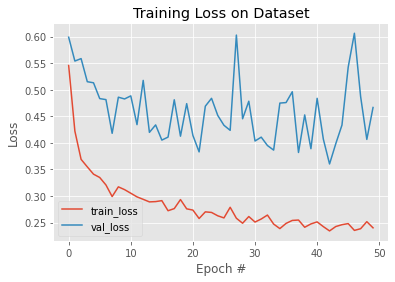

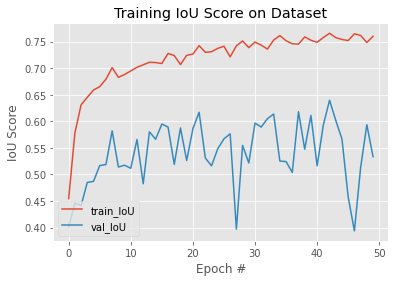

In [ ]:
# Best Model Path
model_path = os.path.join(models_path, "bn_checkpoint_unet.pth")

# Load Model
model = UNet_BN().to(DEVICE)
model, optimizer, scaler, states = load_checkpoint(model, model_path)
History = states['history']

# 1. plot the loss curve
plt.style.use("ggplot")
plt.figure()
plt.plot(History["train_loss"], label="train_loss")
plt.plot(History["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
x = plt.show()

# Save the loss curve figure
# plt.savefig()

# 2. plot the IoU score curve
plt.style.use("ggplot")
plt.figure()
plt.plot(History["train_IoU"], label="train_IoU")
plt.plot(History["val_IoU"], label="val_IoU")
plt.title("Training IoU Score on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("IoU Score")
plt.legend(loc="lower left")
x = plt.show()

# Save the loss curve figure
# plt.savefig()

In [ ]:
# Train Loss and train accuracy at best epoch
print(History["train_loss"][42])
print(History["train_IoU"][42]*100,'%')

0.23440517
76.55948996543884 %


> ## 4. FCN Training <br>

>> ### Fine-tuning

1. lr = 0.1

In [ ]:
# Model Paths
best_model_path = os.path.join(models_path, "finetuning_0.1_best_fcn.pth")
checkpoint_model_path = os.path.join(models_path, "finetuning_0.1_checkpoint_fcn.pth")

# Predictions Path
predictions_path = os.path.join(fcn_val_predictions_path, "Finetuning")

# Choose learning rate
initial_lr = 0.1

# Create model
model = FCN_VGG16().to(DEVICE)

# Train model
model, History = train(model, 5, small_train_loader, val_loader, 
          best_model_path, checkpoint_model_path, predictions_path,
          load_from_checkpoint=None,
          initial_lr=initial_lr)

             - Validation: 100%|██████████| 5/5 [02:31<00:00, 30.36s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8057842254638672, Avg Train IoU = 0.19421567022800446, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:48<00:00,  9.64s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8058115243911743, Avg Train IoU = 0.19418847560882568, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:47<00:00,  9.54s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8062129020690918, Avg Train IoU = 0.19378729164600372, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:48<00:00,  9.61s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8058038949966431, Avg Train IoU = 0.1941962093114853, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:47<00:00,  9.57s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8065523505210876, Avg Train IoU = 0.19344770908355713, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  

Best val_loss = 0.8097643852233887 , Best val_score = 0.19023564457893372 at Epoch 1.


1. lr = 0.01

In [ ]:
# Model Paths
best_model_path = os.path.join(models_path, "finetuning_0.01_best_fcn.pth")
checkpoint_model_path = os.path.join(models_path, "finetuning_0.01_checkpoint_fcn.pth")

# Predictions Path
predictions_path = os.path.join(fcn_val_predictions_path, "Finetuning")

# Choose learning rate
initial_lr = 0.01

# Create model
model = FCN_VGG16().to(DEVICE)

# Train model
model, History = train(model, 5, small_train_loader, val_loader, 
          best_model_path, checkpoint_model_path, predictions_path,
          load_from_checkpoint=None,
          initial_lr=initial_lr)

             - Validation: 100%|██████████| 5/5 [00:47<00:00,  9.59s/it, IoU_score=0, loss=1]


Avg Train Loss = 1.0, Avg Train IoU = 0.0, Avg Val Loss = 1.0, Avg Val IoU = 0.0  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:48<00:00,  9.72s/it, IoU_score=0, loss=1]


Avg Train Loss = 1.0, Avg Train IoU = 0.0, Avg Val Loss = 1.0, Avg Val IoU = 0.0  



             - Validation: 100%|██████████| 5/5 [00:48<00:00,  9.68s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8115888833999634, Avg Train IoU = 0.18841131031513214, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:48<00:00,  9.63s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8061374425888062, Avg Train IoU = 0.19386248290538788, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:48<00:00,  9.73s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8059313297271729, Avg Train IoU = 0.19406884908676147, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  

Best val_loss = 0.8097643852233887 , Best val_score = 0.19023564457893372 at Epoch 3.


2. lr = 0.001

In [ ]:
# Model Paths
best_model_path = os.path.join(models_path, "finetuning_0.001_best_fcn.pth")
checkpoint_model_path = os.path.join(models_path, "finetuning_0.001_checkpoint_fcn.pth")

# Predictions Path
predictions_path = os.path.join(fcn_val_predictions_path, "Finetuning")

# Choose learning rate
initial_lr = 0.001

# Create model
model = FCN_VGG16().to(DEVICE)

# Train model
model, History = train(model, 5, small_train_loader, small_val_loader, 
          best_model_path, checkpoint_model_path, predictions_path,
          load_from_checkpoint=None,
          initial_lr=initial_lr)

             - Validation: 100%|██████████| 5/5 [00:48<00:00,  9.65s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8060154914855957, Avg Train IoU = 0.19398444890975952, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:48<00:00,  9.62s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8061449527740479, Avg Train IoU = 0.19385510683059692, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:47<00:00,  9.59s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8053645491600037, Avg Train IoU = 0.1946352869272232, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:48<00:00,  9.61s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8064402937889099, Avg Train IoU = 0.19355961680412292, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:48<00:00,  9.72s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8064283728599548, Avg Train IoU = 0.1935717612504959, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  

Best val_loss = 0.8097643852233887 , Best val_score = 0.19023564457893372 at Epoch 1.


3. lr = 0.0001

In [ ]:
# Model Paths
best_model_path = os.path.join(models_path, "finetuning_0.0001_best_fcn.pth")
checkpoint_model_path = os.path.join(models_path, "finetuning_0.0001_checkpoint_fcn.pth")

# Predictions Path
predictions_path = os.path.join(fcn_val_predictions_path, "Finetuning")

# Choose learning rate
initial_lr = 0.0001

# Create model
model = FCN_VGG16().to(DEVICE)

# Train model
model, History = train(model, 5, small_train_loader, small_val_loader, 
          best_model_path, checkpoint_model_path, predictions_path,
          load_from_checkpoint=None,
          initial_lr=initial_lr)

             - Validation: 100%|██████████| 5/5 [02:08<00:00, 25.69s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8057842254638672, Avg Train IoU = 0.19421567022800446, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:50<00:00, 10.10s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8058115243911743, Avg Train IoU = 0.19418847560882568, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:49<00:00,  9.92s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8062129020690918, Avg Train IoU = 0.19378729164600372, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:49<00:00,  9.88s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8058038949966431, Avg Train IoU = 0.1941962093114853, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:49<00:00,  9.98s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8065523505210876, Avg Train IoU = 0.19344770908355713, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  

Best val_loss = 0.8097643852233887 , Best val_score = 0.19023564457893372 at Epoch 1.


>> ### Training from scratch 

In [ ]:
# Model Paths
best_model_path = os.path.join(models_path, "trial_best_fcn.pth")
checkpoint_model_path = os.path.join(models_path, "trial_checkpoint_fcn.pth")

# Predictions Path
predictions_path = os.path.join(fcn_val_predictions_path, "Trial")

# Choose learning rate
initial_lr = 1e-3

# Create model
model = FCN_VGG16().to(DEVICE)

# Train model
model, History = train(model, 50, train_loader, val_loader, 
          best_model_path, checkpoint_model_path, predictions_path,
          load_from_checkpoint='last',
          initial_lr=initial_lr)

=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/trial_best_fcn.pth'
=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/trial_checkpoint_fcn.pth'
Model has been trained for 45 epochs with best_IoU = 0.1902 and best_loss = 0.8098 at epoch 1



             - Validation: 100%|██████████| 5/5 [01:17<00:00, 15.56s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8057842254638672, Avg Train IoU = 0.19421567022800446, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.37s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8058115243911743, Avg Train IoU = 0.19418847560882568, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.38s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8062129020690918, Avg Train IoU = 0.19378729164600372, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.38s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8058038949966431, Avg Train IoU = 0.1941962093114853, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.38s/it, IoU_score=0.438, loss=0.562]


Avg Train Loss = 0.8065523505210876, Avg Train IoU = 0.19344770908355713, Avg Val Loss = 0.8097643852233887, Avg Val IoU = 0.19023564457893372  

Best val_loss = 0.8097643852233887 , Best val_score = 0.19023564457893372 at Epoch 1.


Get Train Results for best epoch

In [ ]:
# Best Model Path
model_path = os.path.join(models_path, "trial_checkpoint_fcn.pth")

# Load Model
model = FCN_VGG16().to(DEVICE)
model, optimizer, scaler, states = load_checkpoint(model, model_path)
History = states['history']

# Train Loss and train accuracy at best epoch
print(History["train_loss"][0])
print(History["train_IoU"][0]*100,'%')

=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/trial_checkpoint_fcn.pth'
0.8057842
19.421567022800446 %


>> ### Training using ImageNet weights

In [ ]:
# Model Paths
best_model_path = os.path.join(models_path, "pretrained_best_fcn.pth")
checkpoint_model_path = os.path.join(models_path, "pretrained_checkpoint_fcn.pth")

# Predictions Path
predictions_path = os.path.join(fcn_val_predictions_path, "Pretrained")

# Choose learning rate
initial_lr = 1e-4

# Create model
model = FCN_VGG16(pretrained=True).to(DEVICE)

# Train model
model, History = train(model, 50, train_loader, val_loader, 
          best_model_path, checkpoint_model_path, predictions_path,
          load_from_checkpoint='best',
          initial_lr=initial_lr)

=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/pretrained_best_fcn.pth'
Model has been trained for 5 epochs with best_IoU = 0.1891 and best_loss = 0.8109 at epoch 5



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.30s/it, IoU_score=0, loss=1]



Avg Validation Loss= 1.0, Avg Validation IoU = 0.0



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.32s/it, IoU_score=0.444, loss=0.556]



Avg Validation Loss= 0.7686507105827332, Avg Validation IoU = 0.23134927451610565
=> saved best model



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.31s/it, IoU_score=0.298, loss=0.702]



Avg Validation Loss= 0.8678284883499146, Avg Validation IoU = 0.13217148184776306



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.22s/it, IoU_score=0.416, loss=0.584]



Avg Validation Loss= 0.8147791028022766, Avg Validation IoU = 0.1852208822965622



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.20s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143162727355957, Avg Validation IoU = 0.18568377196788788



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.25s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568412959575653



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.28s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568412959575653



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.20s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568412959575653



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.30s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568412959575653



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.26s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568411469459534



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.25s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143157958984375, Avg Validation IoU = 0.1856841892004013



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.22s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568412959575653



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.17s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568412959575653



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.20s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143159747123718, Avg Validation IoU = 0.18568406999111176



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.18s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143159747123718, Avg Validation IoU = 0.18568404018878937



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.25s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568412959575653



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.13s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568412959575653



             - Validation: 100%|██████████| 5/5 [00:34<00:00,  6.99s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568411469459534



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.02s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568408489227295



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.26s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568411469459534



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.23s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143159747123718, Avg Validation IoU = 0.18568404018878937



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.21s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568406999111176



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.18s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568411469459534



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.16s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143159747123718, Avg Validation IoU = 0.18568406999111176



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.21s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143159747123718, Avg Validation IoU = 0.18568401038646698



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.13s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568408489227295



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.20s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143159747123718, Avg Validation IoU = 0.18568406999111176



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.14s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143159747123718, Avg Validation IoU = 0.18568408489227295



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.19s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568411469459534



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.16s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568412959575653



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.10s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568408489227295



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.09s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568411469459534



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.21s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568411469459534



             - Validation: 100%|██████████| 5/5 [00:35<00:00,  7.13s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143159747123718, Avg Validation IoU = 0.1856839954853058



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.21s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568412959575653



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.21s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568408489227295



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.22s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568412959575653



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.29s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143159747123718, Avg Validation IoU = 0.18568406999111176



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.24s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568408489227295



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.25s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143159747123718, Avg Validation IoU = 0.18568406999111176



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.25s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143159747123718, Avg Validation IoU = 0.18568404018878937



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.30s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568415939807892



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.24s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143159747123718, Avg Validation IoU = 0.1856839954853058



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.26s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.814315915107727, Avg Validation IoU = 0.18568411469459534



             - Validation: 100%|██████████| 5/5 [00:36<00:00,  7.30s/it, IoU_score=0.418, loss=0.582]



Avg Validation Loss= 0.8143157958984375, Avg Validation IoU = 0.1856842041015625

Best val_loss = 0.7686507105827332 , Best val_score = 0.23134927451610565 at Epoch 7.


Get Train Results for best epoch

In [ ]:
# Best Model Path
model_path = os.path.join(models_path, "pretrained_checkpoint_fcn.pth")

# Load Model
model = FCN_VGG16().to(DEVICE)
model, optimizer, scaler, states = load_checkpoint(model, model_path)
History = states['history']

# Train Loss and train accuracy at best epoch
print(History["train_loss"][6])
print(History["train_IoU"][6]*100,'%')

=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/pretrained_checkpoint_fcn.pth'
0.3492568
65.07432460784912 %


# 8. Test

Dataset and dataloader

In [ ]:
test_dataset = ISIC_Dataset(directory = test_dir, transform = train_transform)

print(f"[INFO] found {len(test_dataset)} examples in the test set...")

# create the test data loader
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

[INFO] found 600 examples in the test set...


> ## 1. Best UNet Model

In [ ]:
# Best Model Path (To be edited)
best_model_path = os.path.join(models_path, "trial_best_unet.pth")

# Load Model
model = UNet().to(DEVICE)
model, optimizer, scaler, states = load_checkpoint(model, best_model_path)

# Test
loss, IoU = test(model,test_loader, unet_test_predictions_path)

=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/trial_best_unet.pth'


Testing: : 100%|██████████| 19/19 [02:46<00:00,  8.77s/it, IoU_score=0.714, loss=0.287]


Avg Test Loss = 0.3576013445854187, Avg Test IoU = 0.6424763202667236


> ## 2. Best FCN Model

In [ ]:
# Best Model Path (TO BE ADDED)
best_model_path = os.path.join(models_path, "pretrained_best_fcn.pth")


# Load Model
model = FCN_VGG16(pretrained=True).to(DEVICE)
model, optimizer, scaler, states = load_checkpoint(model, best_model_path)

# Test
loss, IoU = test(model,test_loader,fcn_test_predictions_path)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

=> loaded checkpoint '/content/drive/MyDrive/ISIC-2017/Models/pretrained_best_fcn.pth'


Testing: : 100%|██████████| 19/19 [05:06<00:00, 16.13s/it, IoU_score=0.0446, loss=0.943]


Avg Test Loss = 0.7741149067878723, Avg Test IoU = 0.2086348980665207
